In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.15.0
TF Hub version: 0.15.0
GPU available


Load, Unzip and Dive into Dataset.

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d moulhanout/stanford-dogs-dataset

 97% 729M/751M [00:11<00:00, 126MB/s]
100% 751M/751M [00:11<00:00, 70.1MB/s]


In [ ]:
!unzip stanford-dogs-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/Images/n02108089-boxer/n02108089_11875.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_122.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12232.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_125.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12738.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12739.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12827.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13340.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13526.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1353.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1355.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1357.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1367.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13738.jpg  
  inflating: images/Images/n02108089-boxer/n021

In [ ]:
unique_breeds = []

for folders in os.listdir("/content/images/Images"):
    breed = "".join(folders.split("-")[1:])
    unique_breeds.append(breed)

# Converts to sorted ndarray
unique_breeds = np.array(sorted(unique_breeds))
len(unique_breeds), unique_breeds[:10]

(120,
 array(['Afghan_hound', 'African_hunting_dog', 'Airedale',
        'American_Staffordshire_terrier', 'Appenzeller',
        'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog',
        'Blenheim_spaniel', 'Border_collie'], dtype='<U30'))

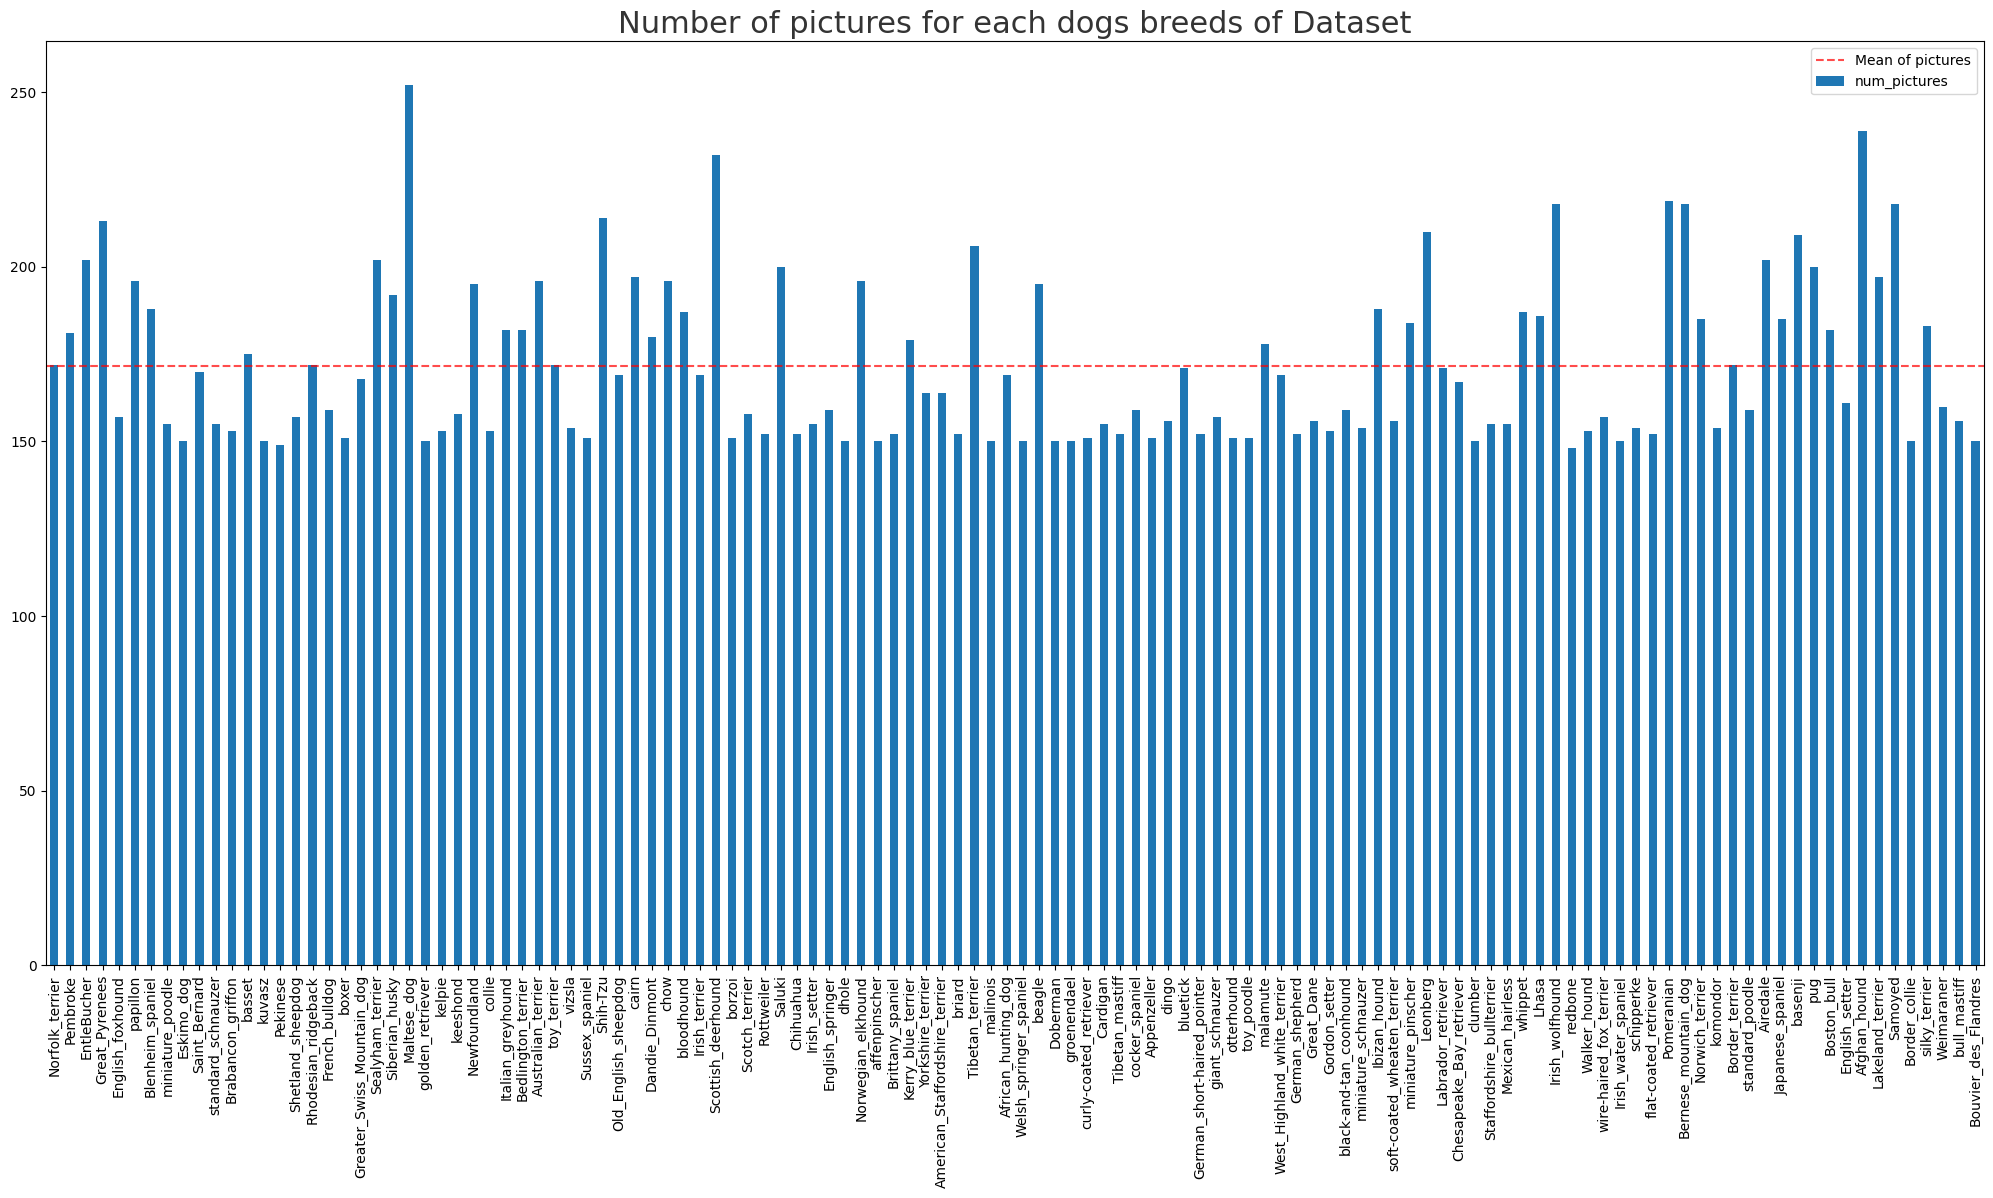

In [ ]:
# Count number of pictures for each breed
images_dir = '/content/images/Images'
breed_list = os.listdir(images_dir)
df_breeds = pd.DataFrame(
    index=[breed.split('-',1)[1]
           for breed in breed_list],
    data=[len(os.listdir(images_dir + "/" + name))
          for name in breed_list],
    columns=["num_pictures"])

# Plot results
fig, ax = plt.subplots(1, 1, figsize=(25,12))
df_breeds.plot(kind="bar",
               legend=False,
               ax=ax)
ax.axhline(df_breeds["num_pictures"].mean(),
           color='r', alpha=.7,
           linestyle='--',
           label="Mean of pictures")
plt.title("Number of pictures for each "\
          "dogs breeds of Dataset",
          color="#343434", fontsize=22)
plt.legend()
plt.show()

Create Data Pipeline for model_0.

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

def image_data_pipeline(path, img_size=IMG_SIZE, batch_size=BATCH_SIZE, test_data=False, seed=42):

    def retrieve_data_from_path(path, test_data=False):
        filenames = []
        # Test data image retrieval (not separated per class)
        if test_data:
            for files in os.listdir(path):
                filenames.append(f"{path}/{files}")
            return np.array(filenames)

        # Train and val data image retrieval
        else:
            for folders in os.listdir(path):
                for files in os.listdir(f"{path}/{folders}"):
                    filenames.append(f"{path}/{folders}/{files}")
            filenames = np.array(filenames)
            np.random.shuffle(filenames)
            labels = np.array(["".join(name.split('/')[-2].split("-")[1:]) for name in filenames])
            unique_breeds = np.unique(labels)
            boolean_labels = np.array([label == unique_breeds for label in labels]).astype(int)
            return filenames, boolean_labels

    def process_image(filename, img_size=IMG_SIZE):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, size=[img_size, img_size])
        return image

    def configure_tensor(ds, shuffle=False):
        if shuffle: # For train set
            ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds


    if test_data:
        print(f"Creating test data batches... BATCH SIZE={batch_size}")
        x = retrieve_data_from_path(path, test_data=True)
        x_test = tf.data.Dataset.from_tensor_slices(x).map(process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        return configure_tensor(x_test)

    else:
        print(f"Creating train & validation data batches... BATCH SIZE={batch_size}")
        x, y = retrieve_data_from_path(path)
        x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=seed)
        x_train = tf.data.Dataset.from_tensor_slices(x_train).map(process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        x_valid = tf.data.Dataset.from_tensor_slices(x_valid).map(process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        y_train = tf.data.Dataset.from_tensor_slices(y_train)
        y_valid = tf.data.Dataset.from_tensor_slices(y_valid)
        train_data = tf.data.Dataset.zip((x_train, y_train))
        valid_data = tf.data.Dataset.zip((x_valid, y_valid))
        return configure_tensor(train_data, shuffle=True), configure_tensor(valid_data)


In [ ]:
train_data, valid_data = image_data_pipeline(images_dir)
train_data.element_spec, valid_data.element_spec

Creating train & validation data batches... BATCH SIZE=32


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.int64, name=None)))

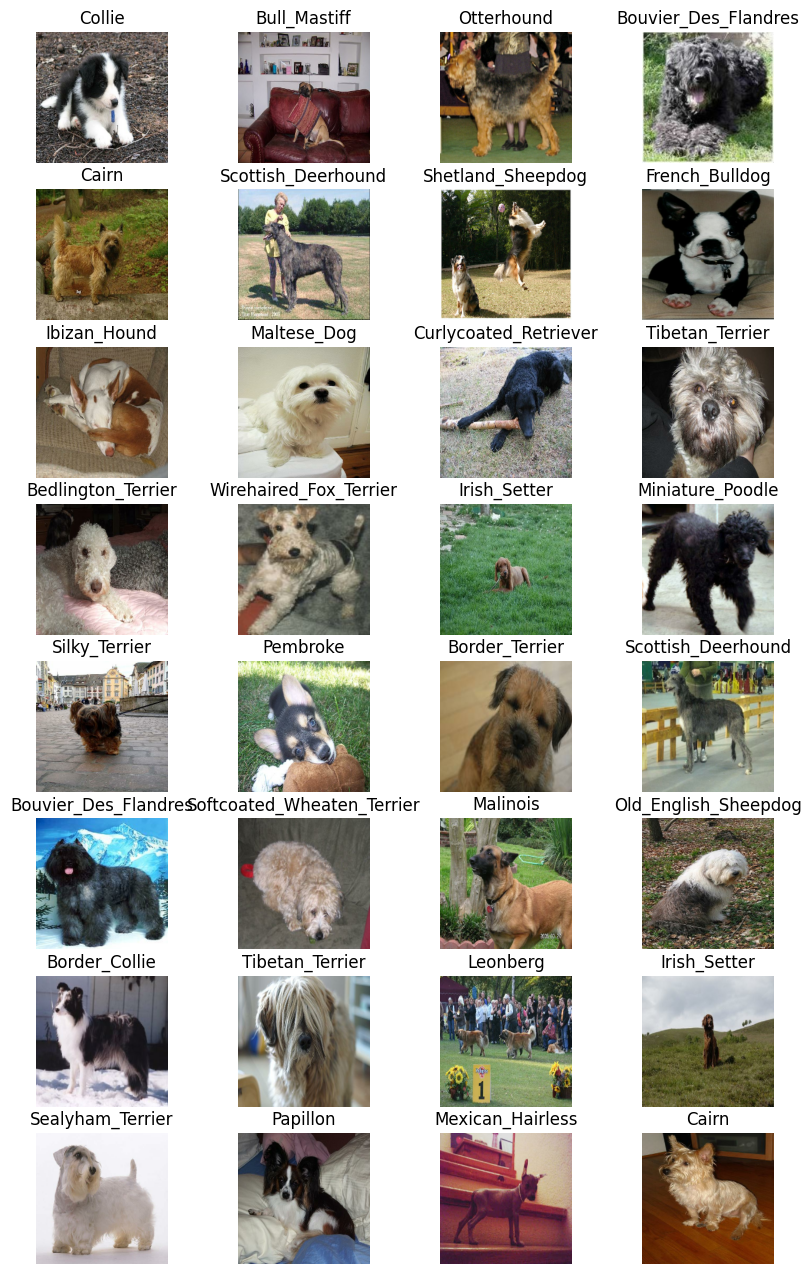

In [ ]:
def show_batch(image_batch, label_batch):
  fig = plt.figure(figsize=(10,16))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(8,4,n+1)
      plt.imshow(image_batch[n])
      plt.title(unique_breeds[label_batch[n]==1][0].title(), fontsize=12)
      plt.axis('off')

image_batch, label_batch = next(train_data.as_numpy_iterator())
show_batch(image_batch, label_batch)

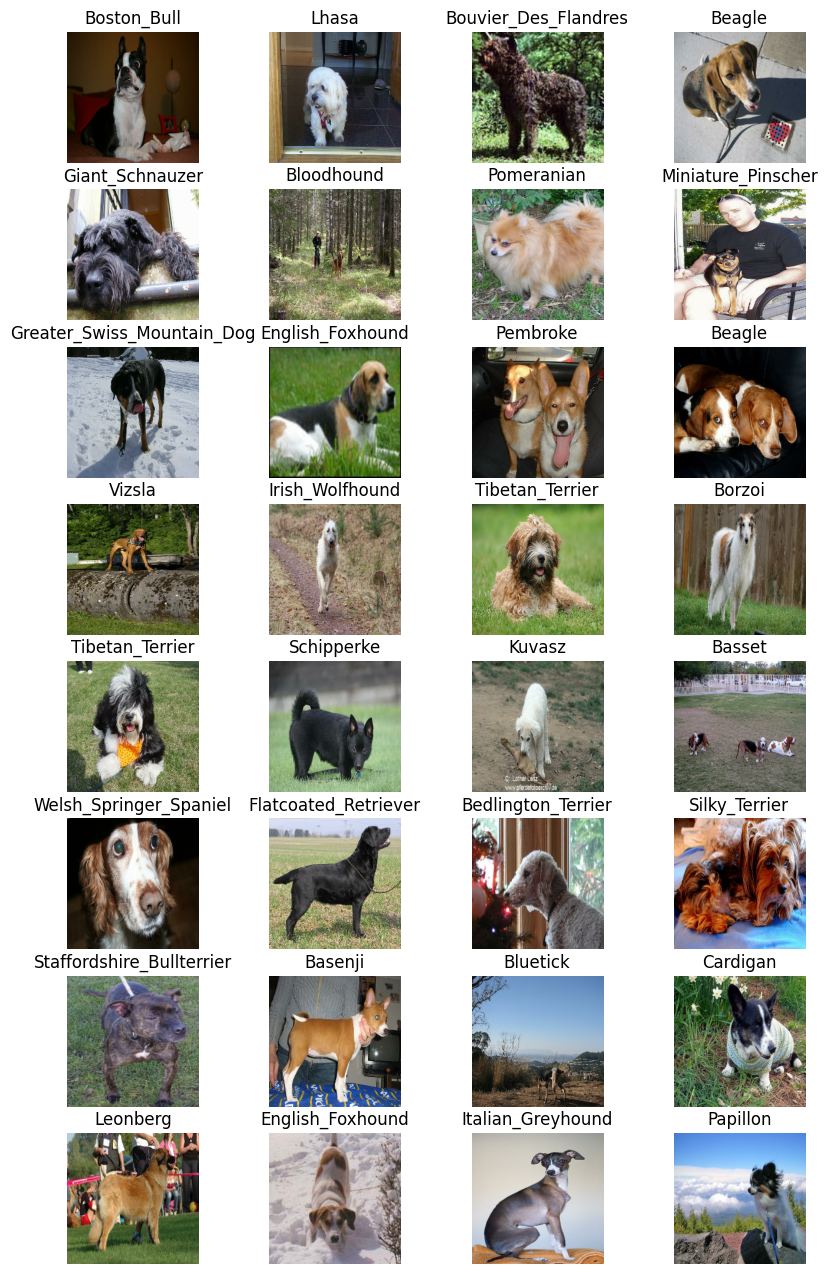

In [ ]:
valid_image, valid_label = next(valid_data.as_numpy_iterator())
show_batch(valid_image, valid_label)

Creating the base model layer by mobilenet_v3.

In [ ]:
INPUT_SHAPE = [None,IMG_SIZE, IMG_SIZE, 3] #batch, height, width, colour channel
OUTPUT_SHAPE = len(unique_breeds)
MODEL_URL = "https://www.kaggle.com/models/google/mobilenet-v3/frameworks/TensorFlow2/variations/large-100-224-feature-vector/versions/1"

In [ ]:
base_model = hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v3/frameworks/TensorFlow2/variations/large-100-224-feature-vector/versions/1")
base_model.trainable = False
len(base_model.trainable_variables)

0

Creating model_0.

In [ ]:
# Setup Layers
model_0 = tf.keras.Sequential([
    base_model, # Layer 1 (Input Layer)
    tf.keras.layers.Dense(units=512, activation="relu"), # Hidden Layer
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=256, activation="relu"), # Hidden Layer
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, activation="softmax") # Layer 4 (Output Layer)
])


# Compiling the model
base_learning_rate = 0.0001
model_0.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
      metrics =["accuracy"]
)

# Build Model
model_0.build(INPUT_SHAPE)
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              4226432   
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 120)               30840     
                                                                 
Total params: 5044472 (19.24 MB)
Trainable params: 81804

In [ ]:
len(model_0.trainable_variables)

6

In [ ]:
def create_model_checkpoint(dir, suffix=None):
    modeldir = os.path.join(dir, "Models",
                          datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%s"))

    model_path = modeldir + "-" + suffix
    print(f"Model will be saved to `{model_path}`")
    return tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_accuracy',save_best_only=True)

In [ ]:
# EPOCHS
NUM_EPOCHS = 100

# Create callback
checkpoint = create_model_checkpoint("Notebook_Outputs", "MobileNetV3_100_Adam_20580")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=5)

# Model Training
model_0_history = model_0.fit(x=train_data,
                    epochs=NUM_EPOCHS,
                    validation_data=valid_data,
                    validation_freq=1,
                    callbacks=[early_stopping, checkpoint],
                )

Model will be saved to `Notebook_Outputs/Models/2024_01_24-17_17_1706116636-MobileNetV3_100_Adam_20580`
Epoch 1/100
515/515 [==============================] - 62s 98ms/step - loss: 2.9961 - accuracy: 0.4071 - val_loss: 0.9902 - val_accuracy: 0.7675
Epoch 2/100
515/515 [==============================] - 46s 86ms/step - loss: 0.9632 - accuracy: 0.7343 - val_loss: 0.6497 - val_accuracy: 0.8071
Epoch 3/100
515/515 [==============================] - 47s 88ms/step - loss: 0.6976 - accuracy: 0.7976 - val_loss: 0.5852 - val_accuracy: 0.8151
Epoch 4/100
515/515 [==============================] - 47s 88ms/step - loss: 0.5823 - accuracy: 0.8237 - val_loss: 0.5522 - val_accuracy: 0.8263
Epoch 5/100
515/515 [==============================] - 47s 88ms/step - loss: 0.4923 - accuracy: 0.8488 - val_loss: 0.5353 - val_accuracy: 0.8321
Epoch 6/100
515/515 [==============================] - 45s 86ms/step - loss: 0.4345 - accuracy: 0.8681 - val_loss: 0.5245 - val_accuracy: 0.8345
Epoch 7/100
515/515 [=====

<Axes: >

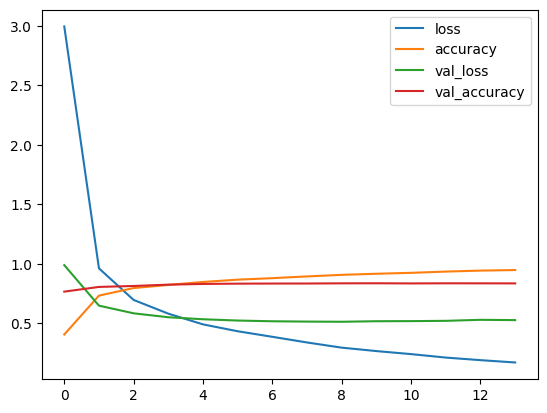

In [ ]:
import pandas as pd
pd.DataFrame(model_0_history.history).plot()

In [ ]:
model_0.evaluate(valid_data)

129/129 [==============================] - 8s 61ms/step - loss: 0.5281 - accuracy: 0.8367


[0.5280753970146179, 0.8367347121238708]

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

def aug_image_data_pipeline(path, img_size=IMG_SIZE, batch_size=BATCH_SIZE, test_data=False, seed=42):

    def retrieve_data_from_path(path, test_data=False):
        filenames = []
        # Test data image retrieval (not separated per class)
        if test_data:
            for files in os.listdir(path):
                filenames.append(f"{path}/{files}")
            return np.array(filenames)

        # Train and val data image retrieval
        else:
            for folders in os.listdir(path):
                for files in os.listdir(f"{path}/{folders}"):
                    filenames.append(f"{path}/{folders}/{files}")
            filenames = np.array(filenames)
            np.random.shuffle(filenames)
            labels = np.array(["".join(name.split('/')[-2].split("-")[1:]) for name in filenames])
            unique_breeds = np.unique(labels)
            boolean_labels = np.array([label == unique_breeds for label in labels]).astype(int)
            return filenames, boolean_labels

    def process_image(filename, img_size=IMG_SIZE):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, size=[img_size, img_size])
        return image
    # Define augmentation functions
    def process_augment_image(filename, img_size=IMG_SIZE):
        # Random left-right flip
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, size=[img_size, img_size])

        image = tf.image.random_flip_left_right(image)

        # Random up-down flip
        image = tf.image.random_flip_up_down(image)

        # Random rotation (between -45 and 45 degrees)
        image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

        return image

    def configure_tensor(ds, shuffle=False):
        if shuffle: # For train set
            ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds




    if test_data:
        print(f"Creating test data batches... BATCH SIZE={batch_size}")
        x = retrieve_data_from_path(path, test_data=True)
        x_ = process_image(x)

        # useing process_augment_image for data process and augmentaion.
        x_test = tf.data.Dataset.from_tensor_slices(x_).map(process_augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        return configure_tensor(x_test)

    else:
        print(f"Creating train & validation data batches... BATCH SIZE={batch_size}")
        x, y = retrieve_data_from_path(path)
        x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=seed)
        # useing process_augment_image for data process and augmentaion.
        x_train = tf.data.Dataset.from_tensor_slices(x_train).map(process_augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        x_valid = tf.data.Dataset.from_tensor_slices(x_valid).map(process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        y_train = tf.data.Dataset.from_tensor_slices(y_train)
        y_valid = tf.data.Dataset.from_tensor_slices(y_valid)
        train_data = tf.data.Dataset.zip((x_train, y_train))
        valid_data = tf.data.Dataset.zip((x_valid, y_valid))
        return configure_tensor(train_data, shuffle=True), configure_tensor(valid_data)


In [ ]:
train_data_aug, valid_data = aug_image_data_pipeline(images_dir)
train_data.element_spec, valid_data.element_spec

Creating train & validation data batches... BATCH SIZE=32


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.int64, name=None)))

Show a batch of agumneted images.

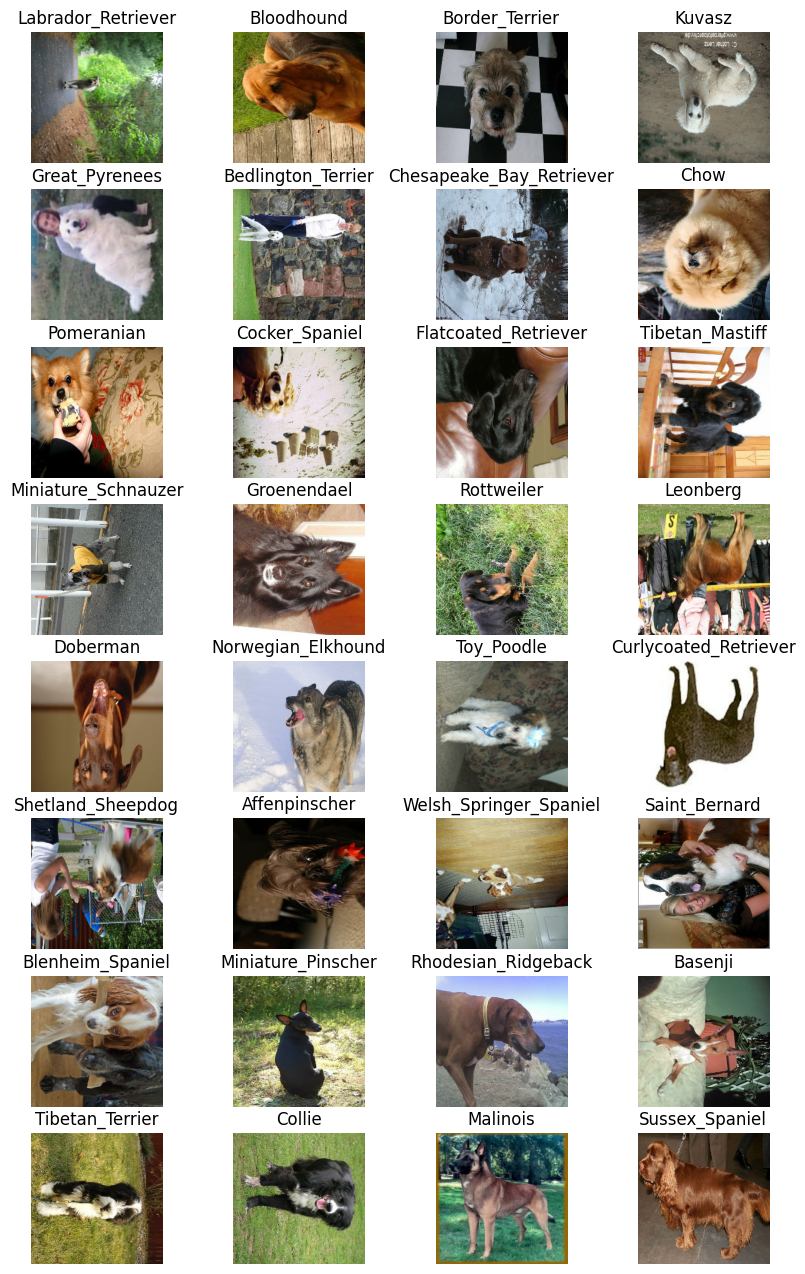

In [ ]:
image_batch, label_batch = next(train_data_aug.as_numpy_iterator())
show_batch(image_batch, label_batch)

Creating model_1 same as model_0.

In [ ]:
# Setup Layers
model_1 = tf.keras.Sequential([
    base_model, # Layer 1 (Input Layer)
    tf.keras.layers.Dense(units=512, activation="relu"), # Hidden Layer
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=256, activation="relu"), # Hidden Layer
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, activation="softmax") # Layer 4 (Output Layer)
])


# Compiling the model
base_learning_rate = 0.0001
model_1.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
      metrics =["accuracy"]
)

# Build Model
model_1.build(INPUT_SHAPE)
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              4226432   
                                                                 
 dense_3 (Dense)             (None, 512)               655872    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 120)               30840     
                                                                 
Total params: 5044472 (19.24 MB)
Trainable params: 818

In [ ]:
# EPOCHS
NUM_EPOCHS = 100

# Create callback
checkpoint = create_model_checkpoint("Notebook_Outputs", "MobileNetV3_100_Adam_20580")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=5)

# Model Training
model_1_aug_history = model_1.fit(x=train_data_aug,
                    epochs=NUM_EPOCHS,
                    validation_data=valid_data,
                    validation_freq=1,
                    callbacks=[early_stopping, checkpoint],
                )

Model will be saved to `Notebook_Outputs/Models/2024_01_24-17_33_1706117595-MobileNetV3_100_Adam_20580`
Epoch 1/100
515/515 [==============================] - 60s 107ms/step - loss: 3.8989 - accuracy: 0.1855 - val_loss: 2.0761 - val_accuracy: 0.6633
Epoch 2/100
515/515 [==============================] - 53s 100ms/step - loss: 2.1019 - accuracy: 0.4724 - val_loss: 0.9904 - val_accuracy: 0.7614
Epoch 3/100
515/515 [==============================] - 56s 106ms/step - loss: 1.6373 - accuracy: 0.5548 - val_loss: 0.7699 - val_accuracy: 0.7913
Epoch 4/100
515/515 [==============================] - 54s 101ms/step - loss: 1.4414 - accuracy: 0.5995 - val_loss: 0.6844 - val_accuracy: 0.8059
Epoch 5/100
515/515 [==============================] - 58s 106ms/step - loss: 1.3173 - accuracy: 0.6272 - val_loss: 0.6379 - val_accuracy: 0.8149
Epoch 6/100
515/515 [==============================] - 52s 96ms/step - loss: 1.2302 - accuracy: 0.6435 - val_loss: 0.6145 - val_accuracy: 0.8144
Epoch 7/100
515/515 [

In [ ]:
model_0.evaluate(valid_data)

129/129 [==============================] - 40s 314ms/step - loss: 0.1698 - accuracy: 0.9514


[0.16978058218955994, 0.9514091610908508]

<Axes: >

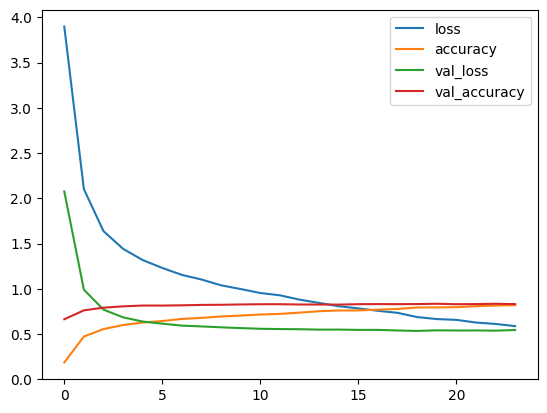

In [ ]:
pd.DataFrame(model_1_aug_history.history).plot()

Let's predict.

In [ ]:
from PIL import Image
import numpy as np

In [ ]:
def load_preprocess_img(image_path, input_shape):
  image = Image.open(image_path)
  image = image.resize(input_shape[:2])

  if image.mode != 'RGB':
    image = image.convert('RGB')
  image = np.array(image)
  image = image/255.

  return image

In [ ]:
input_image_path = '/content/cardigan.jpg'

In [ ]:
input_shape = (224, 224)

input_image = load_preprocess_img(input_image_path, input_shape)

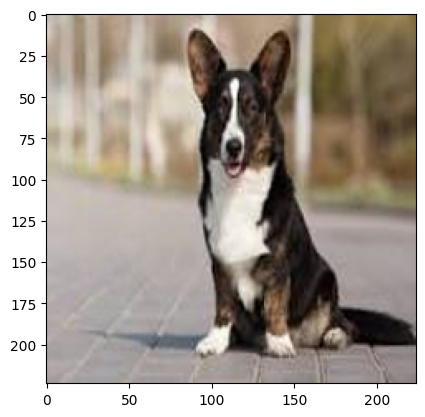

In [ ]:
plt.imshow(input_image)

In [ ]:
input_image_tensor = tf.convert_to_tensor(input_image, dtype=tf.float32)
print(input_image_tensor)

tf.Tensor(
[[[0.7647059  0.7372549  0.7137255 ]
  [0.78431374 0.75686276 0.73333335]
  [0.7921569  0.7647059  0.73333335]
  ...
  [0.5137255  0.43137255 0.25490198]
  [0.5019608  0.41960785 0.24313726]
  [0.5019608  0.41960785 0.24313726]]

 [[0.7607843  0.73333335 0.70980394]
  [0.7764706  0.7490196  0.7254902 ]
  [0.78431374 0.75686276 0.7254902 ]
  ...
  [0.5137255  0.43137255 0.25490198]
  [0.5019608  0.41960785 0.24313726]
  [0.5019608  0.41960785 0.24313726]]

 [[0.7529412  0.7254902  0.7019608 ]
  [0.76862746 0.7411765  0.7137255 ]
  [0.7764706  0.7490196  0.7176471 ]
  ...
  [0.5137255  0.43137255 0.25490198]
  [0.5058824  0.42352942 0.24705882]
  [0.5058824  0.42352942 0.24705882]]

 ...

 [[0.654902   0.62352943 0.6156863 ]
  [0.6509804  0.61960787 0.6117647 ]
  [0.6509804  0.61960787 0.6117647 ]
  ...
  [0.54901963 0.50980395 0.5058824 ]
  [0.54509807 0.5058824  0.5019608 ]
  [0.5411765  0.5019608  0.49803922]]

 [[0.654902   0.62352943 0.6156863 ]
  [0.6509804  0.61960787 0

In [ ]:
pred_prob = model_1.predict(tf.expand_dims(input_image_tensor, axis=0))
pred_prob

1/1 [==============================] - 2s 2s/step


array([[1.75237815e-07, 3.50948758e-05, 6.29689168e-07, 9.87485805e-07,
        3.95464769e-04, 1.17878436e-07, 1.02876108e-07, 6.45540604e-06,
        1.60835714e-06, 5.42163252e-05, 1.76217682e-07, 3.03193847e-05,
        2.44876119e-08, 1.75628224e-06, 1.08333575e-06, 9.97870207e-01,
        5.55505835e-07, 2.01835828e-05, 6.70616487e-07, 3.90804331e-07,
        3.86097054e-05, 1.92774746e-06, 6.17223122e-07, 3.32967247e-05,
        2.60457819e-06, 1.27860756e-06, 7.76098841e-06, 1.65440106e-08,
        3.79596895e-06, 2.18142503e-07, 2.85798876e-07, 2.84459247e-06,
        7.52076585e-06, 1.23643389e-07, 1.05898074e-07, 4.42102930e-07,
        4.17507806e-07, 4.86884062e-07, 4.69755008e-08, 2.67019033e-07,
        3.42635644e-07, 3.56167163e-07, 6.13017619e-07, 6.19420803e-07,
        3.76687730e-08, 7.13580278e-07, 3.85522270e-07, 5.37119007e-08,
        1.94880045e-07, 4.96828747e-08, 1.04198375e-06, 2.04604120e-07,
        7.86489109e-04, 1.61066339e-07, 7.37075879e-06, 1.926934

In [ ]:
prediction = unique_breeds[pred_prob.argmax()]
prediction

'Cardigan'

Let's save the model.

In [ ]:
model_1.save('dog_clf_final.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Calling `save('my_model.keras')` creates a zip archive `my_model.keras`.
model_1.save("dog_model_final.keras")


In [ ]:
unique_breeds

array(['Afghan_hound', 'African_hunting_dog', 'Airedale',
       'American_Staffordshire_terrier', 'Appenzeller',
       'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog',
       'Blenheim_spaniel', 'Border_collie', 'Border_terrier',
       'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon',
       'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever',
       'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound',
       'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog',
       'French_bulldog', 'German_shepherd', 'German_shorthaired_pointer',
       'Gordon_setter', 'Great_Dane', 'Great_Pyrenees',
       'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter',
       'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound',
       'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier',
       'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa',
       'Maltese_dog', 'Mexican_hairless', 'Newfoundland',
       '

Analysis The Result.

In [ ]:
val_pred = model_1.predict(valid_data)

129/129 [==============================] - 9s 63ms/step


In [ ]:
len(val_pred)

4116

In [ ]:
val_pred_class = val_pred.argmax(axis=1)
val_pred_class[:10]

array([ 25, 116,  94,  71,  46,  82,   5, 103,  26,  96])

In [ ]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in valid_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[25, 116, 94, 71, 46, 82, 111, 17, 102, 96]

In [ ]:
# How many labels are there? (should be the same as how many prediction probabilities we have)
len(y_labels)

4116

In [ ]:
val_pred.shape

(4116, 120)

In [ ]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, val_pred_class)
sklearn_accuracy

0.8304178814382897

In [ ]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes is not None and len(classes) > 0:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=val_pred_class,
                      classes=unique_breeds,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, val_pred_class))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95        49
           1       0.94      0.97      0.96        34
           2       0.80      0.91      0.85        44
           3       0.68      0.53      0.60        32
           4       0.75      0.80      0.77        30
           5       0.85      0.90      0.87        50
           6       0.95      0.95      0.95        38
           7       0.89      0.91      0.90        34
           8       0.90      0.90      0.90        39
           9       0.76      0.86      0.81        44
          10       0.82      0.89      0.85        36
          11       0.91      0.89      0.90        36
          12       0.76      0.81      0.79        27
          13       0.89      0.86      0.88        29
          14       0.88      0.85      0.86        33
          15       0.54      0.57      0.55        23
          16       0.91      0.86      0.89        37
          17       0.92    

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, val_pred_class, output_dict=True)
classification_report_dict

{'0': {'precision': 0.9583333333333334,
  'recall': 0.9387755102040817,
  'f1-score': 0.9484536082474228,
  'support': 49},
 '1': {'precision': 0.9428571428571428,
  'recall': 0.9705882352941176,
  'f1-score': 0.9565217391304348,
  'support': 34},
 '2': {'precision': 0.8,
  'recall': 0.9090909090909091,
  'f1-score': 0.8510638297872342,
  'support': 44},
 '3': {'precision': 0.68,
  'recall': 0.53125,
  'f1-score': 0.5964912280701754,
  'support': 32},
 '4': {'precision': 0.75,
  'recall': 0.8,
  'f1-score': 0.7741935483870969,
  'support': 30},
 '5': {'precision': 0.8490566037735849,
  'recall': 0.9,
  'f1-score': 0.8737864077669903,
  'support': 50},
 '6': {'precision': 0.9473684210526315,
  'recall': 0.9473684210526315,
  'f1-score': 0.9473684210526315,
  'support': 38},
 '7': {'precision': 0.8857142857142857,
  'recall': 0.9117647058823529,
  'f1-score': 0.8985507246376812,
  'support': 34},
 '8': {'precision': 0.8974358974358975,
  'recall': 0.8974358974358975,
  'f1-score': 0.8974

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[unique_breeds[int(k)]] = v["f1-score"]
class_f1_scores

{'Afghan_hound': 0.9484536082474228,
 'African_hunting_dog': 0.9565217391304348,
 'Airedale': 0.8510638297872342,
 'American_Staffordshire_terrier': 0.5964912280701754,
 'Appenzeller': 0.7741935483870969,
 'Australian_terrier': 0.8737864077669903,
 'Bedlington_terrier': 0.9473684210526315,
 'Bernese_mountain_dog': 0.8985507246376812,
 'Blenheim_spaniel': 0.8974358974358975,
 'Border_collie': 0.8085106382978724,
 'Border_terrier': 0.8533333333333333,
 'Boston_bull': 0.9014084507042254,
 'Bouvier_des_Flandres': 0.7857142857142857,
 'Brabancon_griffon': 0.8771929824561403,
 'Brittany_spaniel': 0.8615384615384615,
 'Cardigan': 0.5531914893617021,
 'Chesapeake_Bay_retriever': 0.888888888888889,
 'Chihuahua': 0.7333333333333334,
 'Dandie_Dinmont': 0.8787878787878789,
 'Doberman': 0.7755102040816326,
 'English_foxhound': 0.6551724137931034,
 'English_setter': 0.7812499999999999,
 'English_springer': 0.8852459016393444,
 'EntleBucher': 0.8250000000000001,
 'Eskimo_dog': 0.46428571428571425,
 '

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

class_name  f1-score
97                    keeshond  0.985915
81                      borzoi  0.984127
48          Norwegian_elkhound  0.972973
27  German_shorthaired_pointer  0.967742
70                  Weimaraner  0.961538

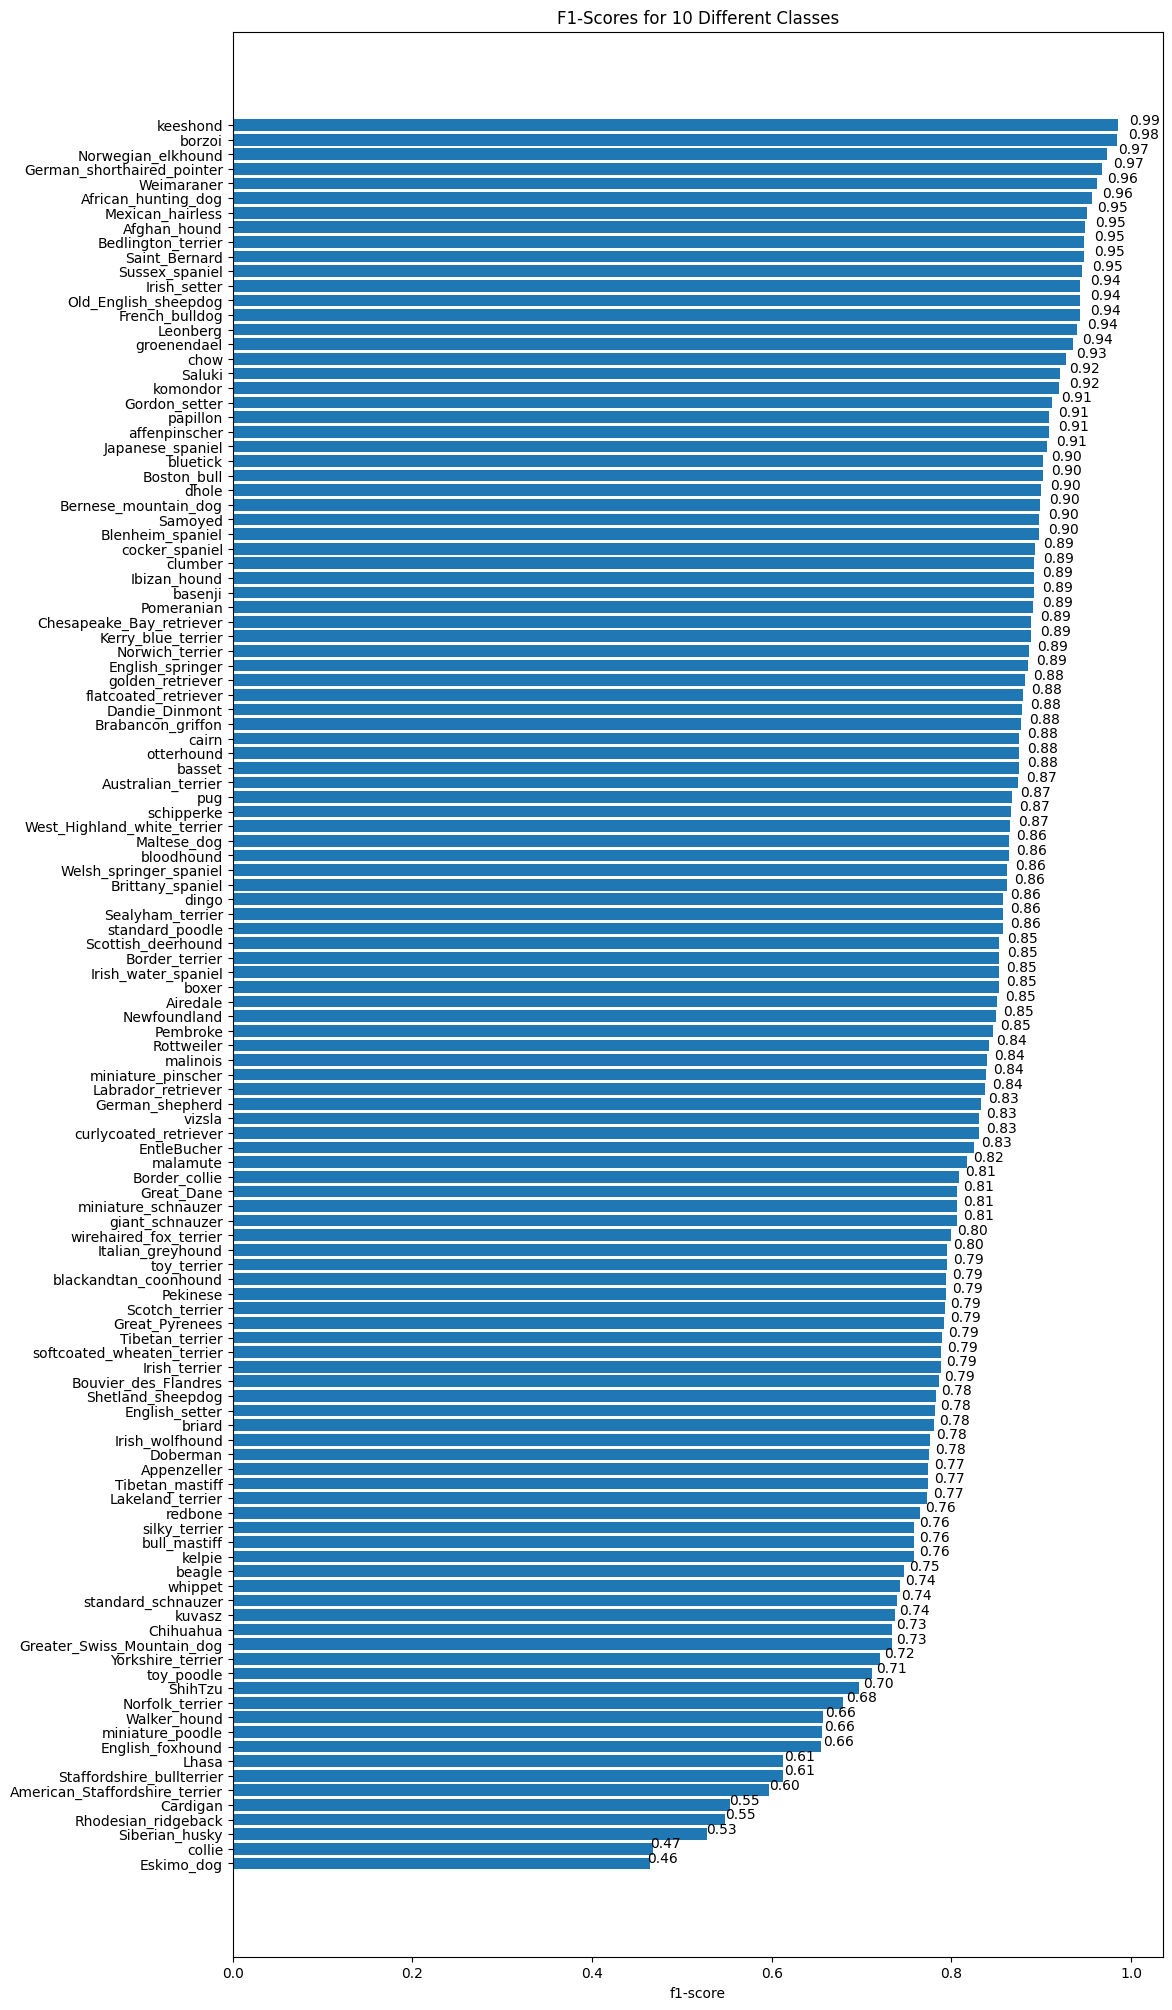

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects):
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)